<a href="https://colab.research.google.com/github/22Himanshu/KPMG_-_PwC_article_resarch_automation/blob/main/KPMG_PWC_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain_google_genai

Successfully accessed GOOGLE_API_KEY1 from Colab Secrets.
Loaded 207 articles.
Initializing embedding model...
Initialized Google Embedding Model: models/text-embedding-004
Generating embeddings...
Embeddings generated successfully.
Performing Elbow Method to determine optimal k...


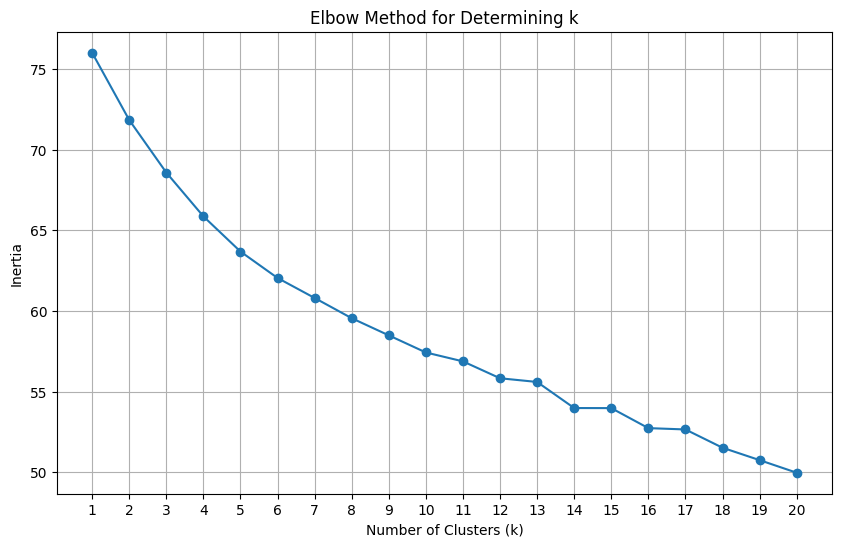

In [2]:
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os # Import the os module to access environment variables
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from google.colab import userdata
GOOGLE_API_KEY_VALUE = userdata.get('GOOGLE_API_KEY1')
# --- Configuration ---
JSON_FILE_PATH = 'extracted_articles.json' # Upload your JSON file to Colab
MAX_K_FOR_ELBOW = 20 # Max number of clusters to test for Elbow Method
EMBEDDING_MODEL_NAME = "models/text-embedding-004"


if not GOOGLE_API_KEY_VALUE:
    print("Error: GOOGLE_API_KEY1 not found in Colab Secrets.")
    exit()
else:
    print("Successfully accessed GOOGLE_API_KEY1 from Colab Secrets.")

articles_data = []
article_contents = []
try:
    with open(JSON_FILE_PATH, 'r', encoding='utf-8') as f:
        articles_data = json.load(f)
        article_contents = [article.get('published_content', '') for article in articles_data]
except FileNotFoundError:
    print(f"Error: File not found at {JSON_FILE_PATH}. Please upload it to your Colab environment.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {JSON_FILE_PATH}. Check the file format.")
    exit()

if not article_contents:
    print("No content found in the JSON file.")
    exit()

print(f"Loaded {len(articles_data)} articles.")


#Initialize Embedder ---
print("Initializing embedding model...")
try:
    embeddings_model = GoogleGenerativeAIEmbeddings(
        model=EMBEDDING_MODEL_NAME,
        google_api_key=GOOGLE_API_KEY_VALUE
    )
    print(f"Initialized Google Embedding Model: {EMBEDDING_MODEL_NAME}")
except Exception as e:
    print(f"Error initializing embedding model: {e}")
    exit()

print("Generating embeddings...")
try:
    article_embeddings = embeddings_model.embed_documents(article_contents)
    article_embeddings_np = np.array(article_embeddings)
    print("Embeddings generated successfully.")
except Exception as e:
    print(f"Error generating embeddings: {e}")
    exit()

print("Performing Elbow Method to determine optimal k...")
inertia = []
k_range = range(1, min(len(articles_data) if articles_data else 2, MAX_K_FOR_ELBOW) + 1) # Handle empty data case

if len(articles_data) < 2:
    print("Need at least 2 articles to perform clustering.")
else:
    for k in k_range:
        if k == 0: continue
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(article_embeddings_np)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Determining k')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()



In [3]:
# Set FINAL_K based on the plot ---
FINAL_K = 7  # Example value - replace with your chosen k

if FINAL_K > 1 and len(articles_data) >= FINAL_K: # Only cluster if k > 1 and enough data
    print(f"\nApplying KMeans clustering with k = {FINAL_K}")
    final_kmeans = KMeans(n_clusters=FINAL_K, random_state=42, n_init= 10)
    final_kmeans.fit(article_embeddings_np)
    cluster_labels = final_kmeans.labels_
    print("Clustering complete.")

for i, article in enumerate(articles_data):
    article['cluster_id'] = int(cluster_labels[i])


print("\nCalculating average within-cluster similarity...")
similarity_scores_by_cluster = {}

if FINAL_K > 1: # Only calculate if there are multiple clusters
    for cluster_id in range(FINAL_K):
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
        if len(cluster_indices) > 1:
            cluster_embeddings = article_embeddings_np[cluster_indices]
            pairwise_sim = cosine_similarity(cluster_embeddings)
            n = len(cluster_indices)
            sum_sim = np.sum(pairwise_sim)
            # Average of the upper triangle excluding the diagonal
            avg_sim = (sum_sim - n) / (n * (n - 1))

            similarity_scores_by_cluster[cluster_id] = avg_sim
        elif len(cluster_indices) == 1:
             similarity_scores_by_cluster[cluster_id] = 1.0
        else:
             similarity_scores_by_cluster[cluster_id] = 0.0


    # Print within-cluster similarity scores
    print("Average Within-Cluster Similarity Scores:")
    if similarity_scores_by_cluster:
        for cluster_id, avg_sim in similarity_scores_by_cluster.items():
            print(f"  Cluster {cluster_id}: {avg_sim:.4f}")
    else:
        print("  No clusters with more than one article to calculate within-cluster similarity.")
else:
    print("Skipping within-cluster similarity calculation as there is only 1 cluster.")

print("\nArticles with assigned Cluster IDs:")
# Save the results to a new JSON file
output_file_path = 'clustered_articles.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(articles_data, f, indent=4)

print(f"\nClustered articles saved to {output_file_path}")


Applying KMeans clustering with k = 7
Clustering complete.

Calculating average within-cluster similarity...
Average Within-Cluster Similarity Scores:
  Cluster 0: 0.5997
  Cluster 1: 0.6060
  Cluster 2: 0.8698
  Cluster 3: 0.7406
  Cluster 4: 0.7029
  Cluster 5: 0.6869
  Cluster 6: 0.6715

Articles with assigned Cluster IDs:

Clustered articles saved to clustered_articles.json


# Lets check

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

used_keywords = set()
cluster_themes = {}
cluster_texts = {}  # Initialize cluster_texts as an empty dictionary

# Assuming you have cluster_labels and article_contents available
for i, label in enumerate(cluster_labels):
    if label not in cluster_texts:
        cluster_texts[label] = []
    cluster_texts[label].append(article_contents[i])

vectorizer = TfidfVectorizer(max_features=100, stop_words='english') # Initialize vectorizer outside the loop

for cluster_id, texts in sorted(cluster_texts.items()):  # sort for consistency
    combined_text = [" ".join(texts)]
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = tfidf_scores.argsort()[::-1]  # Sort by importance
    top_keywords = feature_array[top_indices]

    # Filter out already used keywords
    unique_themes = []
    for word in top_keywords:
        if word not in used_keywords:
            unique_themes.append(word)
            used_keywords.add(word)
        if len(unique_themes) == 2:
            break

    cluster_themes[cluster_id] = unique_themes

# Print the updated themes
for cid, themes in cluster_themes.items():
    print(f"Cluster {cid}: Unique Themes = {themes}")

Cluster 0: Unique Themes = ['tax', 'kpmg']
Cluster 1: Unique Themes = ['ai', 'data']
Cluster 2: Unique Themes = ['insights', 'business']
Cluster 3: Unique Themes = ['value', 'risk']
Cluster 4: Unique Themes = ['technology', 'transformation']
Cluster 5: Unique Themes = ['og', 'legal']
Cluster 6: Unique Themes = ['tariffs', 'global']


In [6]:
import random

articles_by_cluster = {}
for article in articles_data:
    cluster_id = article.get('cluster_id') # Use .get() in case cluster_id wasn't added for some reason
    if cluster_id is not None:
        if cluster_id not in articles_by_cluster:
            articles_by_cluster[cluster_id] = []
        articles_by_cluster[cluster_id].append(article)

print("\n--- Sampling 2 Articles from 5 Clusters ---")

cluster_ids_to_sample = range(min(5, len(articles_by_cluster))) # Sample up to 5 clusters if fewer than 5 exist

for cluster_id in cluster_ids_to_sample:
    articles_in_cluster = articles_by_cluster.get(cluster_id, []) # Get list of articles for this cluster ID

    print(f"\nCluster {cluster_id} (contains {len(articles_in_cluster)} articles):")

    if not articles_in_cluster:
        print("  This cluster is empty or does not exist in the sampled range.")
        continue

    # Determine how many articles to sample (min of 3 or the actual size of the cluster)
    num_samples = min(2, len(articles_in_cluster))

    # Randomly sample articles from the cluster
    sampled_articles = random.sample(articles_in_cluster, num_samples)

    # Print information for the sampled articles
    print("  Sampled Articles:")
    for i, article in enumerate(sampled_articles):
        url = article.get('article_url', 'No URL available')
        content = article.get('published_content', 'No content available')
        # Take the first 200 characters of content as a snippet
        content_snippet = content[:200] + '...' if len(content) > 200 else content

        print(f"    Sample {i+1}:")
        print(f"      URL: {url}")
        # Assuming title is not available, printing content snippet instead
        print(f"      Content Snippet: {content_snippet}")
        # If you find where the title is, you would do:
        # title = article.get('your_title_key', 'Title not available')
        # print(f"      Title: {title}")


print("\n--- End Sampling ---")


--- Sampling 2 Articles from 5 Clusters ---

Cluster 0 (contains 26 articles):
  Sampled Articles:
    Sample 1:
      URL: https://kpmg.com/pl/en/home/insights/2016/04/tax-legal-alerts.html
      Content Snippet: KPMG's most up-to-date publications on important changes in tax law and case law that affect business.
Experts from the Tax Department of KPMG in Poland keep abreast of the latest changes in the law a...
    Sample 2:
      URL: https://kpmg.com/jp/en/home/insights/2016/05/tax.html
      Content Snippet: Latest tax developments
Newsletters on the latest Japanese taxation developments, such as outlines of the annual tax reform.
e-Tax News including short summaries of the latest Japanese taxation develo...

Cluster 1 (contains 39 articles):
  Sampled Articles:
    Sample 1:
      URL: https://kpmg.com/cn/en/home/insights/2018/02/china-economic-monitor.html
      Content Snippet: China Economic Monitor is a quarterly publication providing KPMG Chinaâs insights on Chinaâs ec

In [8]:
!pip install umap-learn

import plotly.express as px
import pandas as pd
import umap

# Assuming you have article_embeddings_np available
# Reduce the dimensionality of the embeddings to 2 using UMAP
embedding_2d = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        metric='cosine').fit_transform(article_embeddings_np)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
# Prepare DataFrame
umap_df = pd.DataFrame({
    "x": embedding_2d[:, 0],
    "y": embedding_2d[:, 1],
    "Cluster": cluster_labels,
    "Theme": [", ".join(cluster_themes[label]) for label in cluster_labels]
})

# Plot with Plotly
fig = px.scatter(
    umap_df, x="x", y="y",
    color=umap_df["Cluster"].astype(str),
    hover_data={"Cluster": True, "Theme": True, "x": False, "y": False},
    title="Interactive UMAP - KPMG Article Clusters",
    opacity=0.8
)

fig.update_traces(marker=dict(size=8, line=dict(width=0)))
fig.update_layout(
    width=900,
    height=700,
    template="plotly_white",
    legend_title="Cluster",
    title_x=0.5
)
fig.show()


## Since above dashboard is interactive, it won't be visible in github so i am adding one more.

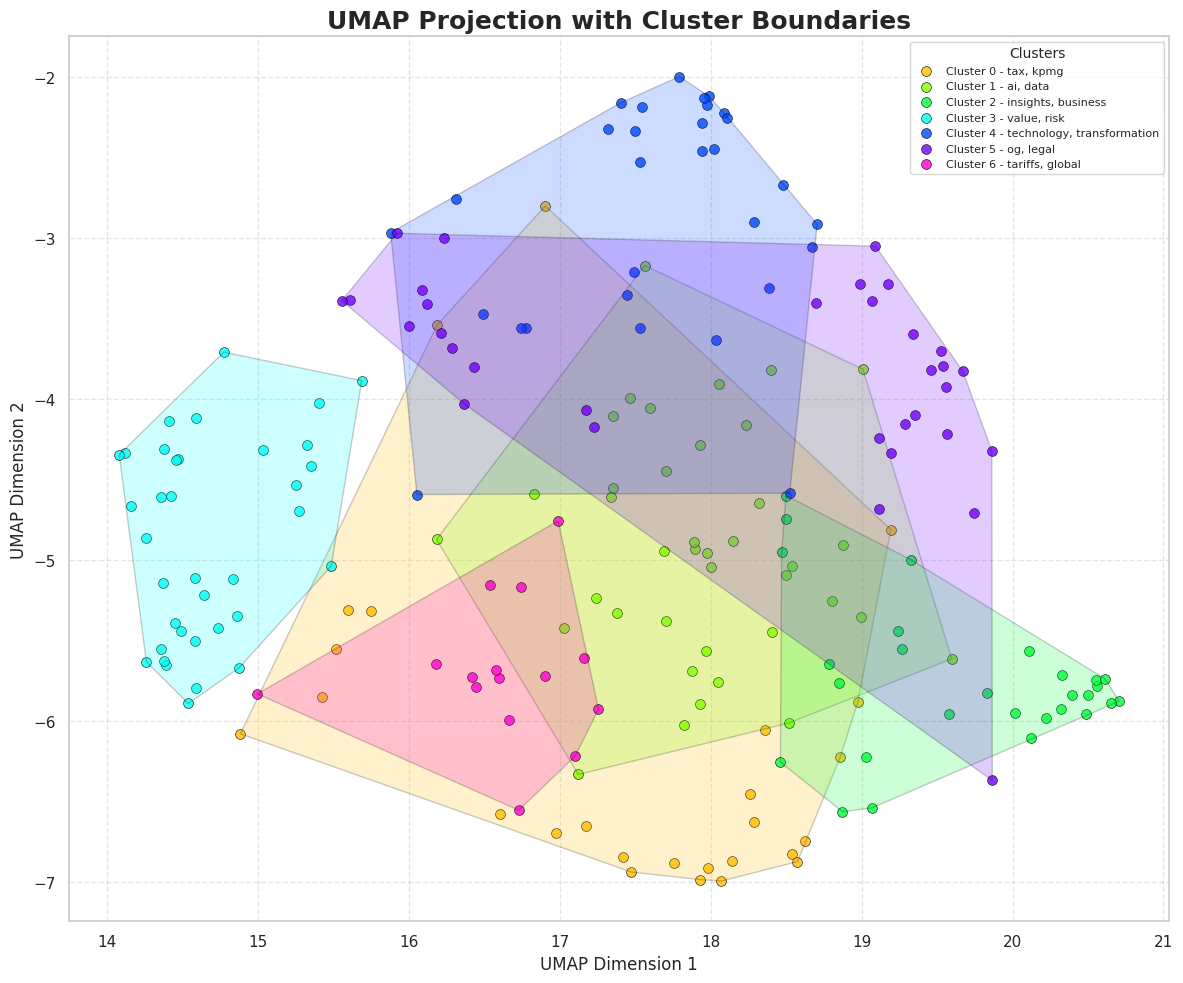

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull

# Better separated colors
palette = sns.color_palette("hsv", n_colors=FINAL_K)

plt.figure(figsize=(12, 10))

for cluster_id in sorted(set(cluster_labels)):
    idx = np.where(np.array(cluster_labels) == cluster_id)[0]
    cluster_points = embedding_2d[idx]

    # Plot points
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=50,
        alpha=0.8,
        label=f"Cluster {cluster_id} - {', '.join(cluster_themes[cluster_id])}",
        color=palette[cluster_id],
        edgecolor='black',
        linewidth=0.5
    )

    # Draw Convex Hull
    if len(cluster_points) >= 3:  # ConvexHull needs at least 3 points
        hull = ConvexHull(cluster_points)
        hull_pts = cluster_points[hull.vertices]
        plt.fill(
            hull_pts[:, 0],
            hull_pts[:, 1],
            alpha=0.2,
            color=palette[cluster_id],
            edgecolor='black',
            linewidth=1.0
        )

# Styling
plt.title("UMAP Projection with Cluster Boundaries", fontsize=18, weight='bold')
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc='best', fontsize=8, frameon=True, title="Clusters", title_fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# !pip install WordCloud

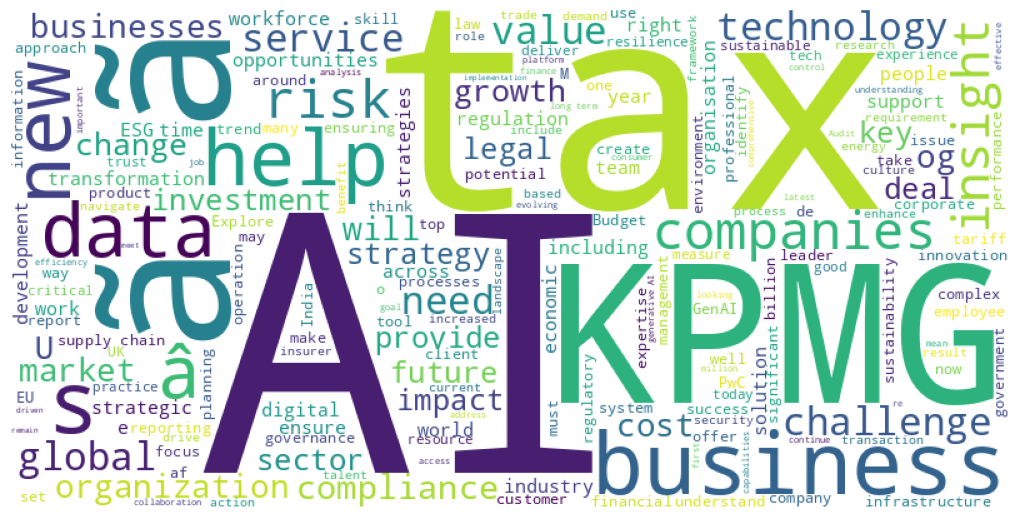

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all article content into a single string
all_article_text = " ".join(article_contents)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_article_text)

# Display the generated image:
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-18-c79ed5619aff>:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-18-c79ed5619aff>:49: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



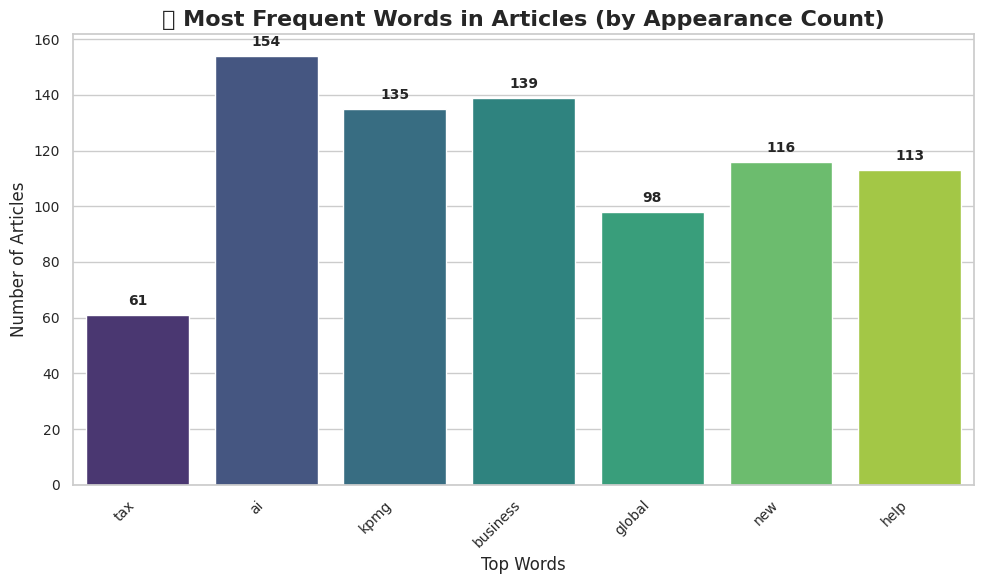

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Setup
stop_words = set(stopwords.words('english'))

# Step 1: Collect and clean words
all_words = []
for article in articles_data:
    content = article.get('published_content', '')
    words = content.lower().split()
    words = [word for word in words if word.isalnum() and word not in stop_words]
    all_words.extend(words)

# Step 2: Most common words
word_counts = Counter(all_words)
top_7_words = [word for word, count in word_counts.most_common(7)]

# Step 3: Article count per word
article_counts = {word: sum(1 for article in articles_data if word in article.get('published_content', '').lower()) for word in top_7_words}

# --- Plot Styling ---
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

bars = sns.barplot(x=list(article_counts.keys()), y=list(article_counts.values()), palette="viridis")

# Add counts above bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),  # Offset text
                  textcoords='offset points',
                  ha='center', va='bottom',
                  fontsize=10, fontweight='bold')

# Final touches
plt.title('📊 Most Frequent Words in Articles (by Appearance Count)', fontsize=16, weight='bold')
plt.xlabel('Top Words', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
